<a href="https://www.kaggle.com/code/rintasetyon/possum-regression-randomforest?scriptVersionId=185595009" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/openintro-possum/possum.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Memuat dataset
data = pd.read_csv('/kaggle/input/openintro-possum/possum.csv')

In [3]:
# Mengganti nama kolom untuk kemudahan
data.columns = ['case', 'site', 'Pop', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']

# Mengubah kolom 'sex' menjadi numerik
data['sex'] = data['sex'].map({'m': 1, 'f': 0})

# Memeriksa nilai unik dalam kolom 'sex'
print("Nilai unik dalam kolom 'sex':", data['sex'].unique())

# Menghapus baris dengan nilai tak terduga di kolom 'sex'
data = data[data['sex'].isin([0, 1])]

Nilai unik dalam kolom 'sex': [1 0]


In [4]:

# Mengisi nilai yang hilang untuk kolom numerik saja
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())


In [5]:

# Standarisasi fitur numerik
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Menghitung matriks korelasi hanya untuk kolom numerik
corr_matrix = data[numeric_columns].corr()
print(corr_matrix['age'].sort_values(ascending=False))
print(corr_matrix['sex'].sort_values(ascending=False))


age         1.000000
belly       0.345825
chest       0.325303
hdlngth     0.311848
skullw      0.279955
totlngth    0.250970
eye         0.234669
footlgth    0.125314
taill       0.117274
earconch    0.052943
sex        -0.063995
site       -0.130799
case       -0.194404
Name: age, dtype: float64
sex         1.000000
case        0.253980
site        0.232817
eye         0.188371
hdlngth     0.107200
skullw      0.080014
taill      -0.040917
age        -0.063995
belly      -0.090777
earconch   -0.091559
footlgth   -0.122964
chest      -0.139074
totlngth   -0.160200
Name: sex, dtype: float64


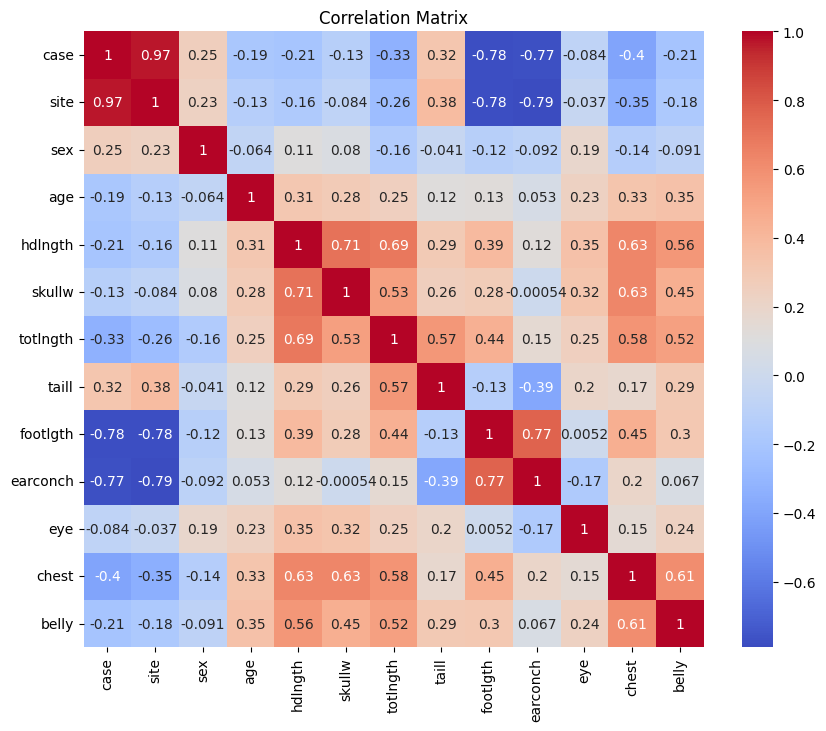

In [6]:

# Visualisasi korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Mean Squared Error: 0.5953786343799277


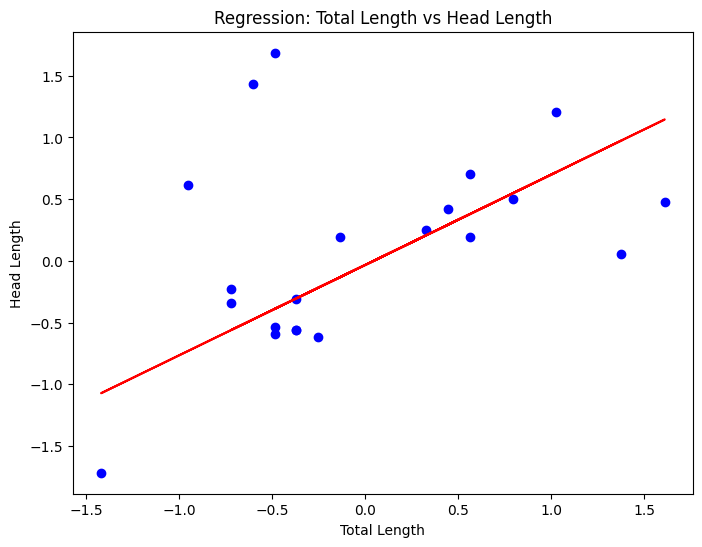

In [7]:

# Menggunakan total length untuk memprediksi panjang kepala possum
X = data[['totlngth']]
y = data['hdlngth']

# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Membuat model regresi linear
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Memprediksi pada testing set
y_pred = regressor.predict(X_test)

# Menghitung Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot hasil regresi
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red')
plt.xlabel('Total Length')
plt.ylabel('Head Length')
plt.title('Regression: Total Length vs Head Length')
plt.show()


In [8]:

# Mengklasifikasikan jenis kelamin possum berdasarkan dimensi tubuh dan lokasi
X = data[['hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly', 'site']]
y = data['sex']

# Memastikan bahwa y adalah tipe integer
y = y.astype(int)

# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Validasi tipe data y_train dan y_test
print(f'Tipe data y_train: {type(y_train)}')
print(f'Tipe data y_test: {type(y_test)}')
print(f'Tipe data elemen y_train: {type(y_train.iloc[0])}')



Tipe data y_train: <class 'pandas.core.series.Series'>
Tipe data y_test: <class 'pandas.core.series.Series'>
Tipe data elemen y_train: <class 'numpy.int64'>


In [9]:

# Hyperparameter Tuning untuk RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [10]:

# Model terbaik dari GridSearch
best_rf_classifier = grid_search.best_estimator_

# Memprediksi pada testing set
y_pred = best_rf_classifier.predict(X_test)

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {accuracy}')


Random Forest Accuracy: 0.7142857142857143


In [11]:

# Menampilkan Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Menampilkan Classification Report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Confusion Matrix:
[[ 3  5]
 [ 1 12]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.75      0.38      0.50         8
           0       0.71      0.92      0.80        13

    accuracy                           0.71        21
   macro avg       0.73      0.65      0.65        21
weighted avg       0.72      0.71      0.69        21



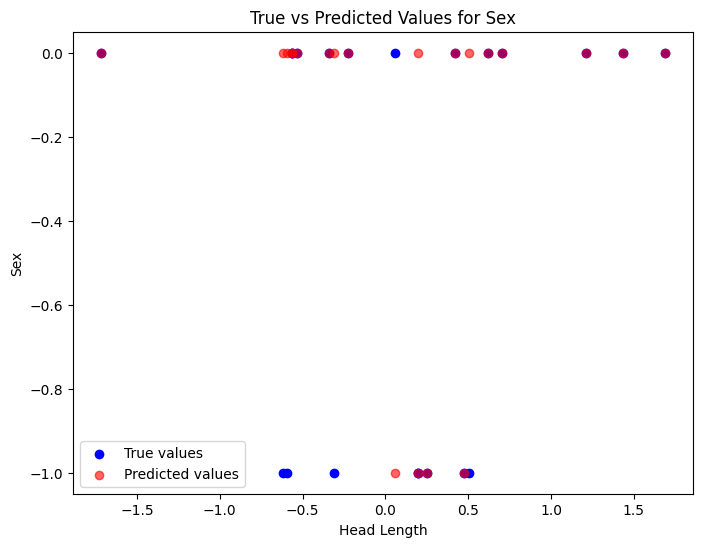

In [12]:
# Visualisasi hasil prediksi
plt.figure(figsize=(8, 6))
plt.scatter(X_test['hdlngth'], y_test, color='blue', label='True values')
plt.scatter(X_test['hdlngth'], y_pred, color='red', alpha=0.6, label='Predicted values')
plt.xlabel('Head Length')
plt.ylabel('Sex')
plt.legend()
plt.title('True vs Predicted Values for Sex')
plt.show()


In [13]:
# Menampilkan hasil prediksi dalam tabel
results_df = X_test.copy()
results_df['True Sex'] = y_test
results_df['Predicted Sex'] = y_pred

# Menampilkan tabel
print("Hasil Prediksi dalam Tabel:")
print(results_df)

Hasil Prediksi dalam Tabel:
     hdlngth    skullw  totlngth     taill  footlgth  earconch       eye  \
30  0.055430 -0.898410  1.378053 -0.004931 -0.105500  1.068382 -0.522479   
65 -0.619461 -0.349744 -0.253734 -0.261331 -1.208229 -0.961168  0.625503   
64  0.252273  0.166648  0.329047  0.507870 -0.059553 -1.572478 -1.000805   
53  1.208369  1.974020  1.028384  3.071874  0.652626 -0.521025  2.347477   
45 -0.338257 -0.801587 -0.719959 -1.030532  0.997229  0.750501 -0.618144   
93 -0.225775  0.231197 -0.719959 -0.774132 -0.978493 -0.741096 -0.618144   
91 -0.535100 -0.188371 -0.486846 -0.004931 -0.197394 -0.325405 -0.522479   
47  1.686417  2.038569 -0.486846 -1.543333 -0.358208 -0.790001  1.869151   
10  0.196032  0.102099  0.562160  1.020671  2.008064  0.774953 -0.139818   
0   0.420996  1.134883  0.445603 -0.517732  1.387779  1.557431  0.147177   
18  0.505357 -0.478842  0.795272 -1.030532  1.135070  1.410716  0.147177   
31  0.477237 -0.059273  1.611166  1.020671  1.456699  0.9461

             case         sex         age     hdlngth      skullw    totlngth  \
count  104.000000  104.000000  104.000000  104.000000  104.000000  104.000000   
mean    52.500000    0.586538    3.833333   92.602885   56.883654   87.088462   
std     30.166206    0.494839    1.890617    3.573349    3.113426    4.310549   
min      1.000000    0.000000    1.000000   82.500000   50.000000   75.000000   
25%     26.750000    0.000000    2.750000   90.675000   54.975000   84.000000   
50%     52.500000    1.000000    3.000000   92.800000   56.350000   88.000000   
75%     78.250000    1.000000    5.000000   94.725000   58.100000   90.000000   
max    104.000000    1.000000    9.000000  103.100000   68.600000   96.500000   

            taill    footlgth    earconch         eye       chest       belly  
count  104.000000  104.000000  104.000000  104.000000  104.000000  104.000000  
mean    37.009615   68.459223   48.130769   15.046154   27.000000   32.586538  
std      1.959518    4.373917 

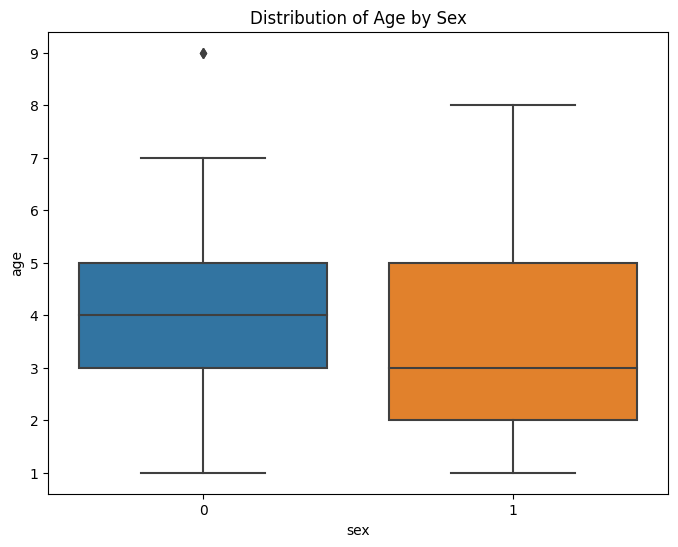

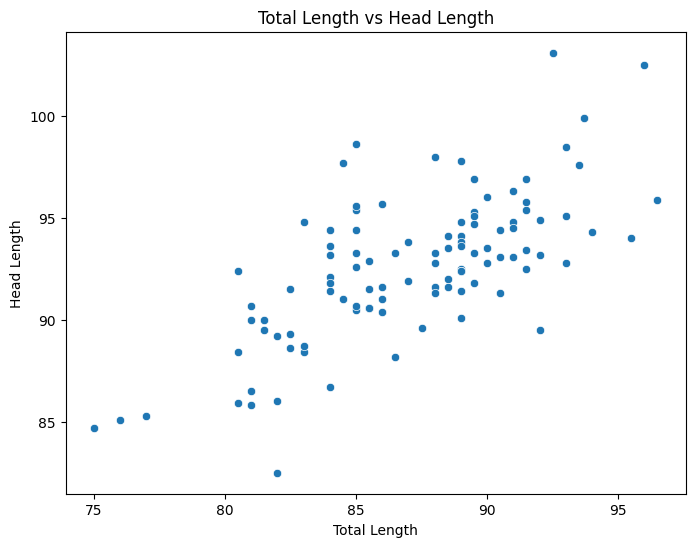

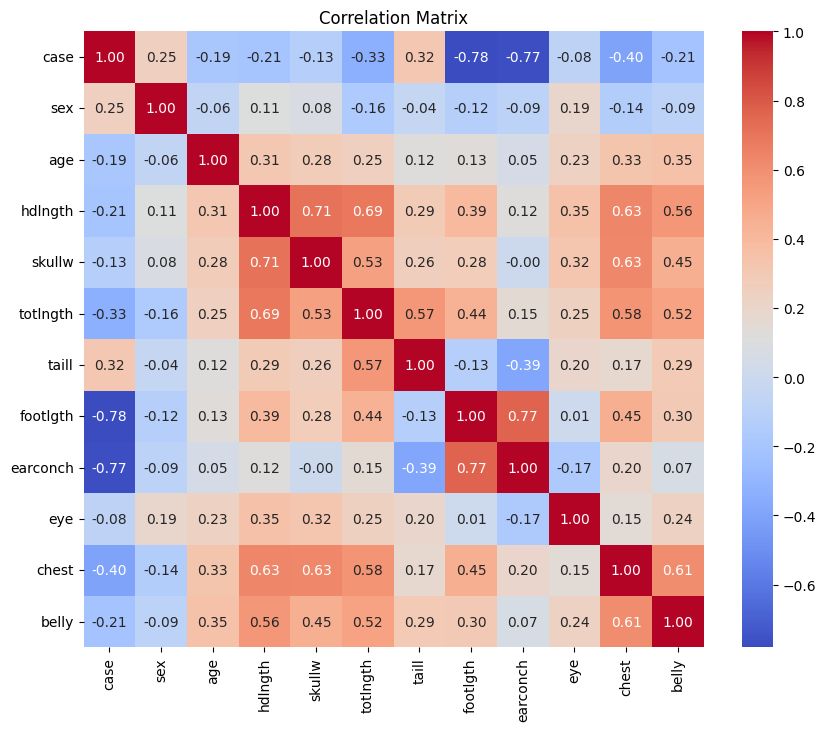

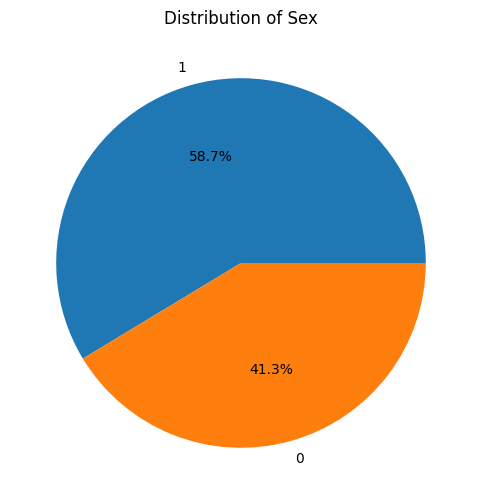

In [14]:


# Memuat dataset
data = pd.read_csv('/kaggle/input/openintro-possum/possum.csv')

# Mengganti nama kolom untuk kemudahan
data.columns = ['case', 'site', 'Pop', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']

# Mengubah kolom 'sex' menjadi numerik
data['sex'] = data['sex'].map({'m': 1, 'f': 0})

# Mengubah kolom 'site' menjadi one-hot encoding
data = pd.get_dummies(data, columns=['site'], drop_first=True)

# Mengisi nilai yang hilang untuk kolom numerik saja
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Statistik Deskriptif
print(data.describe())

# Visualisasi distribusi age berdasarkan sex
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='age', data=data)
plt.title('Distribution of Age by Sex')
plt.show()

# Scatter plot totlngth vs hdlngth
plt.figure(figsize=(8, 6))
sns.scatterplot(x='totlngth', y='hdlngth', data=data)
plt.title('Total Length vs Head Length')
plt.xlabel('Total Length')
plt.ylabel('Head Length')
plt.show()

# Memilih hanya kolom numerik untuk korelasi
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Matriks korelasi
corr_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Distribusi jenis kelamin possum
plt.figure(figsize=(6, 6))
data['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Sex')
plt.ylabel('')
plt.show()
